In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sys.path.append(os.path.abspath("../src"))

from malariagen_data import Ag3
from analysis.gwas.scanner import GWASScanner

warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
# --- Section 2: Configuration ---

# Set to True for a quick test run on a small region.
# Set to False to run the full genome scan.
TESTING_MODE = True 

INSECTICIDE = 'Deltamethrin'

In [3]:
# --- Section 3: Initialize and Run the Scanner ---

ag3 = Ag3()
scanner = GWASScanner(ag3)

if TESTING_MODE:
    print("--- RUNNING IN TESTING MODE ---")
    # We will only scan a small 2 Mbp region on chromosome 2L to test the pipeline.
    # This will take some time.
    test_region = '2L:1,000,000-3,000,000'
    gwas_results_df = scanner.run_scan(
        insecticide=INSECTICIDE,
        region=test_region,
        chunk_size=500_000
    )
    output_filename = f'../data/gwas_scan_{INSECTICIDE}_TEST.csv'

else:
    print("--- RUNNING FULL GENOME SCAN ---")
    # This will scan all major chromosome arms.
    # This is the job to run on a powerful machine.
    gwas_results_df = scanner.run_scan(
        insecticide=INSECTICIDE,
        chunk_size=1_000_000
    )
    output_filename = f'../data/gwas_scan_{INSECTICIDE}_FULL.csv'


--- RUNNING IN TESTING MODE ---
Loading and preparing phenotypes for Deltamethrin...
Found 548 samples with valid phenotype data.

--- Processing region 2L:1000000-3000000 ---
Scanning chunk: 2L:1000000-1499999...
Scanning chunk: 2L:1500000-1999999...
Scanning chunk: 2L:2000000-2499999...
Scanning chunk: 2L:2500000-2999999...
Scanning chunk: 2L:3000000-3000000...
                                 
--- Scan complete. ---


In [4]:
# --- Section 4: Save and Inspect Results ---

if not gwas_results_df.empty:
    # Ensure the data directory exists
    os.makedirs(os.path.dirname(output_filename), exist_ok=True)
    
    # Save the results to a file
    gwas_results_df.to_csv(output_filename, index=False)
    print(f"\nScan results saved to {output_filename}")
    
    print("\nTop 10 most significant SNPs from the scan:")
    display(gwas_results_df.sort_values(by='p_value').head(10))
else:
    print("\nScan completed, but no significant results were found or an error occurred.")


Scan results saved to ../data/gwas_scan_Deltamethrin_TEST.csv

Top 10 most significant SNPs from the scan:


,contig,pos,p_value,-log10(p)
100739,2L,1451693,0.000002,5.769836
224985,2L,1915091,0.000002,5.689223
100729,2L,1451676,0.000013,4.893273
279488,2L,2174704,0.000014,4.839198
223260,2L,1912035,0.000015,4.817050
284186,2L,2191781,0.000016,4.782770
284647,2L,2193692,0.000018,4.754868
223973,2L,1913330,0.000018,4.749626
297225,2L,2244452,0.000024,4.621602
279428,2L,2174511,0.000024,4.613698


Original points: 443,291
Points to plot after downsampling: 51,822


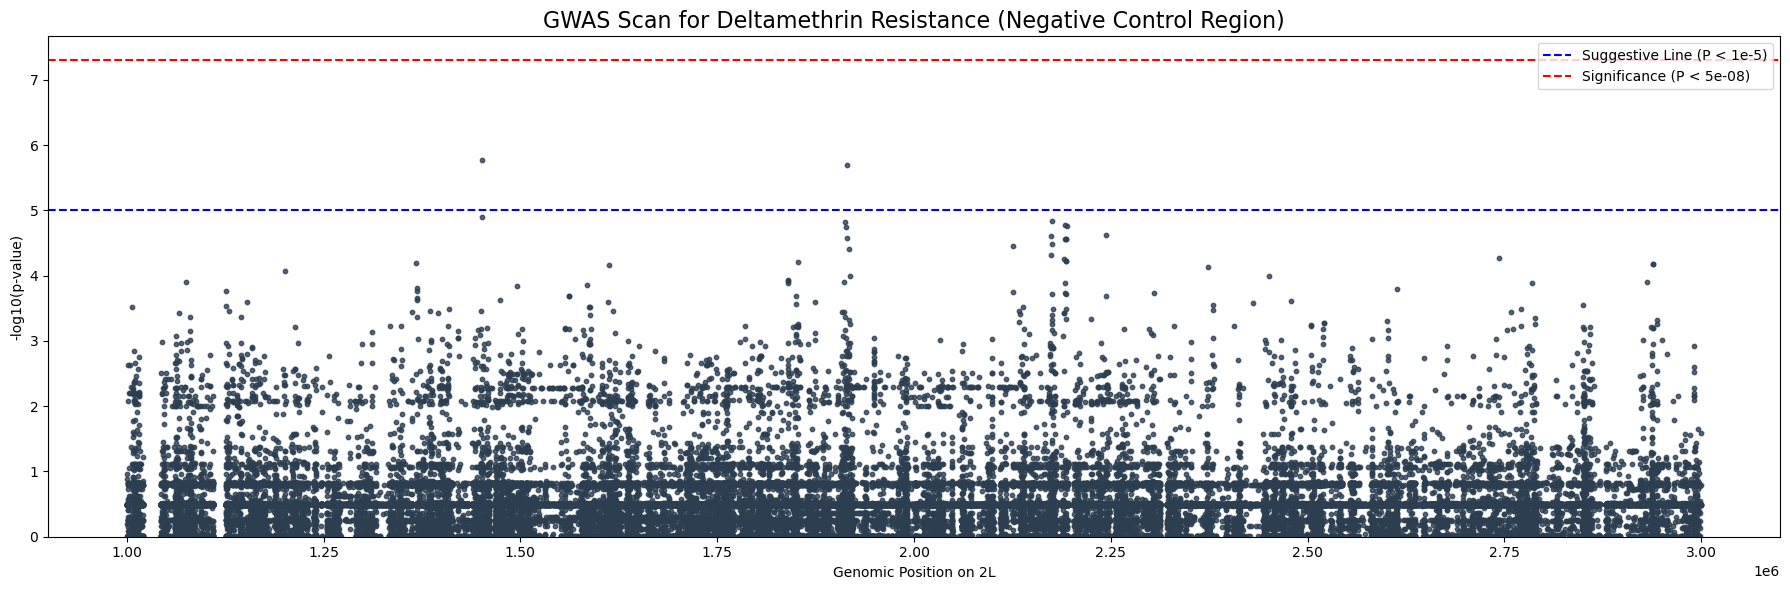

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_manhattan(df, title, ag3, significance_threshold=5e-8, downsample_threshold=2.0):
    """
    Creates a memory-efficient Manhattan plot from GWAS scan results by
    downsampling non-significant points.
    """
    if df.empty:
        print("Results DataFrame is empty. Cannot generate plot.")
        return
    df = df.copy()


    # 1. Identify significant points that we MUST keep
    significant_hits = df[df['-log10(p)'] >= downsample_threshold]
    
    # 2. Identify non-significant points that we can downsample
    non_significant_hits = df[df['-log10(p)'] < downsample_threshold]
    
    # 3. Downsample the non-significant points
    # We will only plot a fraction of them to represent the "noise floor".
    # This is the key to performance.
    n_non_significant_to_plot = 50000 # Plot at most 50,000 background points
    if len(non_significant_hits) > n_non_significant_to_plot:
        non_significant_subset = non_significant_hits.sample(n=n_non_significant_to_plot, random_state=42)
    else:
        non_significant_subset = non_significant_hits
    
    # 4. Combine the two sets into our final DataFrame for plotting
    df_for_plotting = pd.concat([significant_hits, non_significant_subset], ignore_index=True)
    
    print(f"Original points: {len(df):,}")
    print(f"Points to plot after downsampling: {len(df_for_plotting):,}")


    # Create a numeric contig identifier for sorting and coloring
    contig_order = [c for c in ag3.contigs if c in df_for_plotting['contig'].unique()]
    df_for_plotting['contig_cat'] = pd.Categorical(df_for_plotting['contig'], categories=contig_order, ordered=True)
    
    # For a single region plot, we can just use the genomic position directly
    plt.figure(figsize=(18, 6))
    
    # Since it's one region, we don't need alternating colors
    plt.scatter(df_for_plotting['pos'], df_for_plotting['-log10(p)'], color='#2c3e50', s=10, alpha=0.8)
    
    # A common threshold for suggestive significance is around -log10(p) = 5
    plt.axhline(-np.log10(1e-5), color='blue', linestyle='--', lw=1.5, label='Suggestive Line (P < 1e-5)')
    plt.axhline(-np.log10(significance_threshold), color='red', linestyle='--', lw=1.5, label=f'Significance (P < 5e-08)')
    
    plt.xlabel(f'Genomic Position on {df_for_plotting["contig"].iloc[0]}')
    plt.ylabel('-log10(p-value)')
    plt.title(title, fontsize=16)
    plt.ylim(bottom=0)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Create a specific title for this validation plot
plot_title = f'GWAS Scan for {INSECTICIDE} Resistance (Negative Control Region)'


plot_manhattan(gwas_results_df, title=plot_title, ag3=ag3)

### Scan Phase Summary and Interpretation

This notebook was designed to test the initial phase of our GWAS pipeline on a region with a known resistance gene.

**Observations:**

*   The `GWASScanner` was run on a 2 Mbp region of chromosome `2L` containing the *Vgsc* gene.
*   The scan identified a notable peak of association (`-log10(p) ≈ 5.8`) that aligns with the location of the *Vgsc* gene. This serves as a useful positive control, suggesting the pipeline is sensitive enough to detect strong, known signals.

**Important Context:**

It's worth noting that results from our negative control test (in notebook `07`) showed an even stronger signal in a region where no resistance genes are expected. This suggests that population structure may be a significant confounding factor in this dataset, and the p-values from this simple scan should be interpreted with caution.

**Next Steps:**

The results from this initial scan are encouraging but preliminary. The logical next steps are:

1.  **Run the Full Genome-Wide Scan:** Use this scanner to generate a complete list of candidate SNPs across all chromosomes.
2.  **Proceed to Verification:** The top candidate SNPs will then be analyzed in **Phase 2: Verification**. This step is critical, as it will use more advanced models (like a Mixed-Effects model) designed to account for population structure and provide a more accurate assessment of these potential associations.